In [103]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

## Preprocessing

In [104]:
# Load the data
df = pd.read_csv("C:/Users/vinay/Downloads/hotel_booking.csv")

In [105]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [106]:
df.columns 

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'],
      dtype='object')

 Reservation Status, Reservation Status Date are Updated after is cancelled , so it is dropped


In [107]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status','assigned_room_type'], axis=1)

 Removing Personal identification information

In [108]:
# check columns for percentage of missing values
missing = df.isnull().mean()*100
missing[missing > 0]


children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

In [109]:
# Distinct agent and company values
print(df['agent'].nunique())
print(df['company'].nunique())

333
352


Since the number of agents and company is very high and there are many missing values, we can omit these columns

In [110]:
# Drop the 'agent' and 'company' columns
df = df.drop(['agent', 'company'], axis=1)

In [111]:
df.columns 

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'name', 'email', 'phone-number',
       'credit_card'],
      dtype='object')

In [112]:
df['arrival_date_year'].value_counts()

2016    56707
2017    40687
2015    21996
Name: arrival_date_year, dtype: int64

In [113]:
# Arrival date year does not make sense for the model we want to build, so we drop it
df = df.drop(['arrival_date_year'], axis=1)

## Feature Engineering

In [114]:
#Create Number of bookings column counting the number of bookings by name
df['num_bookings'] = df.groupby('name').cumcount()


In [115]:
# Keep country names with more than 1000 bookings rest as 'Other'   
country_counts = df['country'].value_counts()
df['country'] = np.where(df['country'].isin(country_counts.index[country_counts > 1000]), df['country'], 'Other')




Drop PII like name, email, phone number and credit card

In [116]:
df = df.drop(['name', 'email','phone-number', 'credit_card'], axis=1)

## Test Train and Validation Split

In [117]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [118]:
from sklearn.model_selection import train_test_split
test, val = train_test_split(test, test_size=0.5, random_state=42)

In [119]:
print(len(train))
print(len(test))
print(len(val))

83573
17908
17909


In [120]:
# Check for null values
train.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
num_bookings                      0
dtype: int64

In [121]:
#Relace missing values with the 0 for the children column
train['children'] = train['children'].fillna(0)

## Categorical Encoding

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83573 entries, 9710 to 15795
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83573 non-null  object 
 1   is_canceled                     83573 non-null  int64  
 2   lead_time                       83573 non-null  int64  
 3   arrival_date_month              83573 non-null  object 
 4   arrival_date_week_number        83573 non-null  int64  
 5   arrival_date_day_of_month       83573 non-null  int64  
 6   stays_in_weekend_nights         83573 non-null  int64  
 7   stays_in_week_nights            83573 non-null  int64  
 8   adults                          83573 non-null  int64  
 9   children                        83573 non-null  float64
 10  babies                          83573 non-null  int64  
 11  meal                            83573 non-null  object 
 12  country                      

<Axes: >

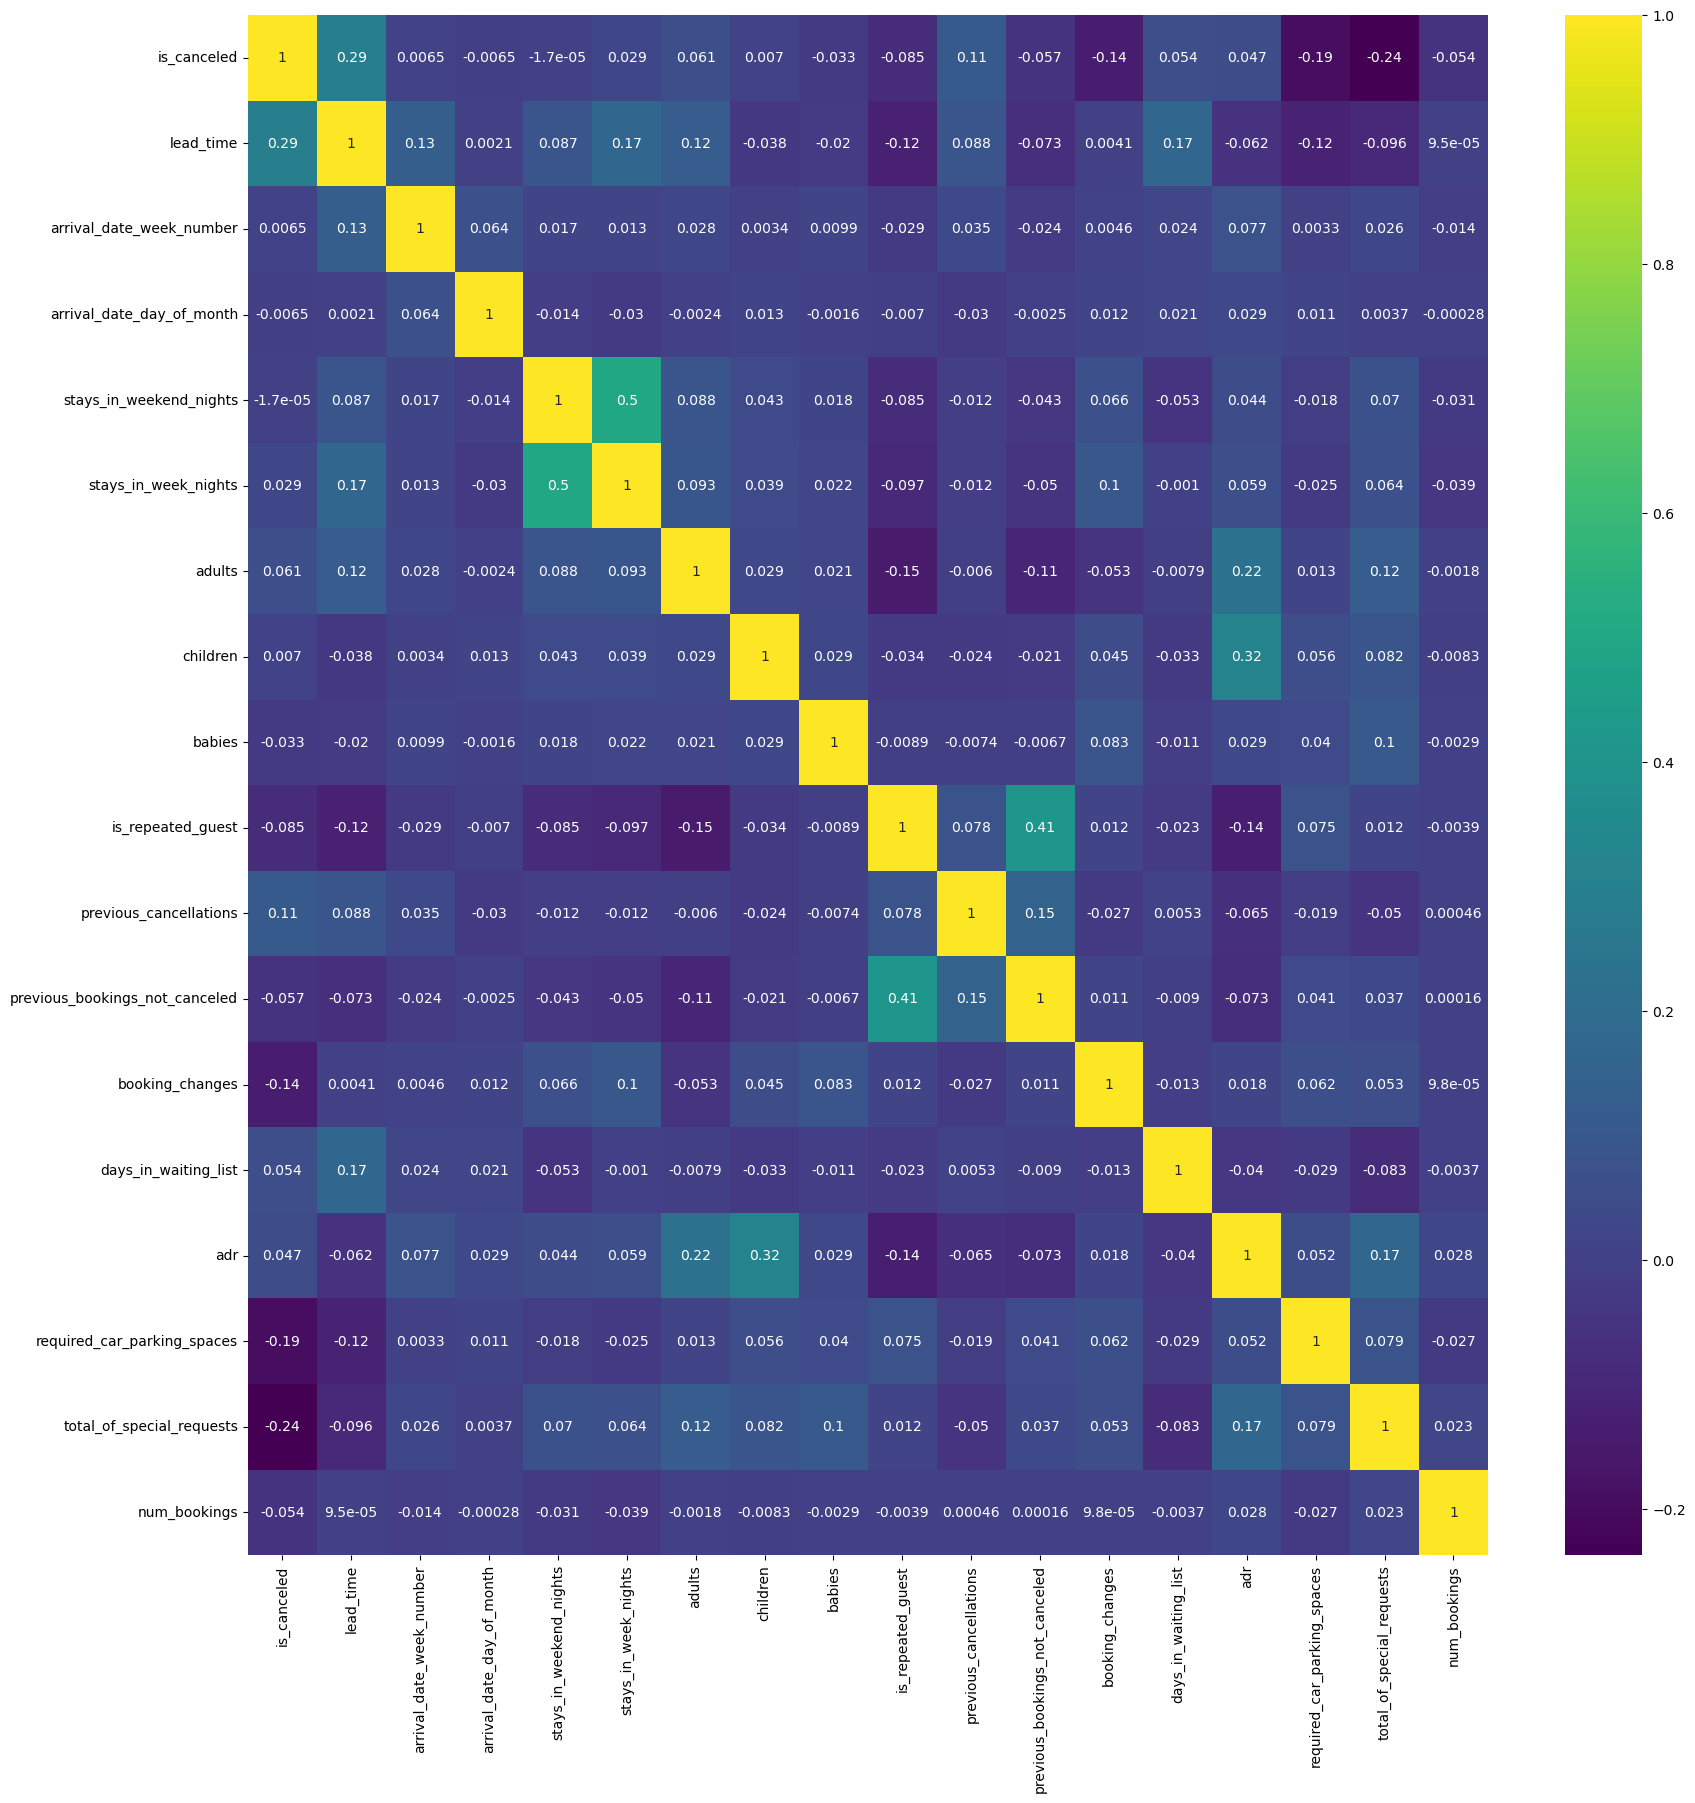

In [123]:
#Plotting a heatmap to check for correlation between the columns
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True, cmap='viridis')

In [124]:
# Using get_dummies to convert categorical columns to numerical columns
train = pd.get_dummies(train, columns=['hotel','arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], drop_first=True)

## Outlier Identification and Treatment

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74]),
 [Text(1, 0, 'is_canceled'),
  Text(2, 0, 'lead_time'),
  Text(3, 0, 'arrival_date_week_number'),
  Text(4, 0, 'arrival_date_day_of_month'),
  Text(5, 0, 'stays_in_weekend_nights'),
  Text(6, 0, 'stays_in_week_nights'),
  Text(7, 0, 'adults'),
  Text(8, 0, 'children'),
  Text(9, 0, 'babies'),
  Text(10, 0, 'is_repeated_guest'),
  Text(11, 0, 'previous_cancellations'),
  Text(12, 0, 'previous_bookings_not_canceled'),
  Text(13, 0, 'booking_changes'),
  Text(14, 0, 'days_in_waiting_list'),
  Text(15, 0, 'adr'),
  Text(16, 0, 'required_car_parking_spaces'),
  Text(17, 0, 'total_of_special_requests'),
  Text(18, 0, 'num_bookings'),
  Text(19, 0, 'hotel_Resor

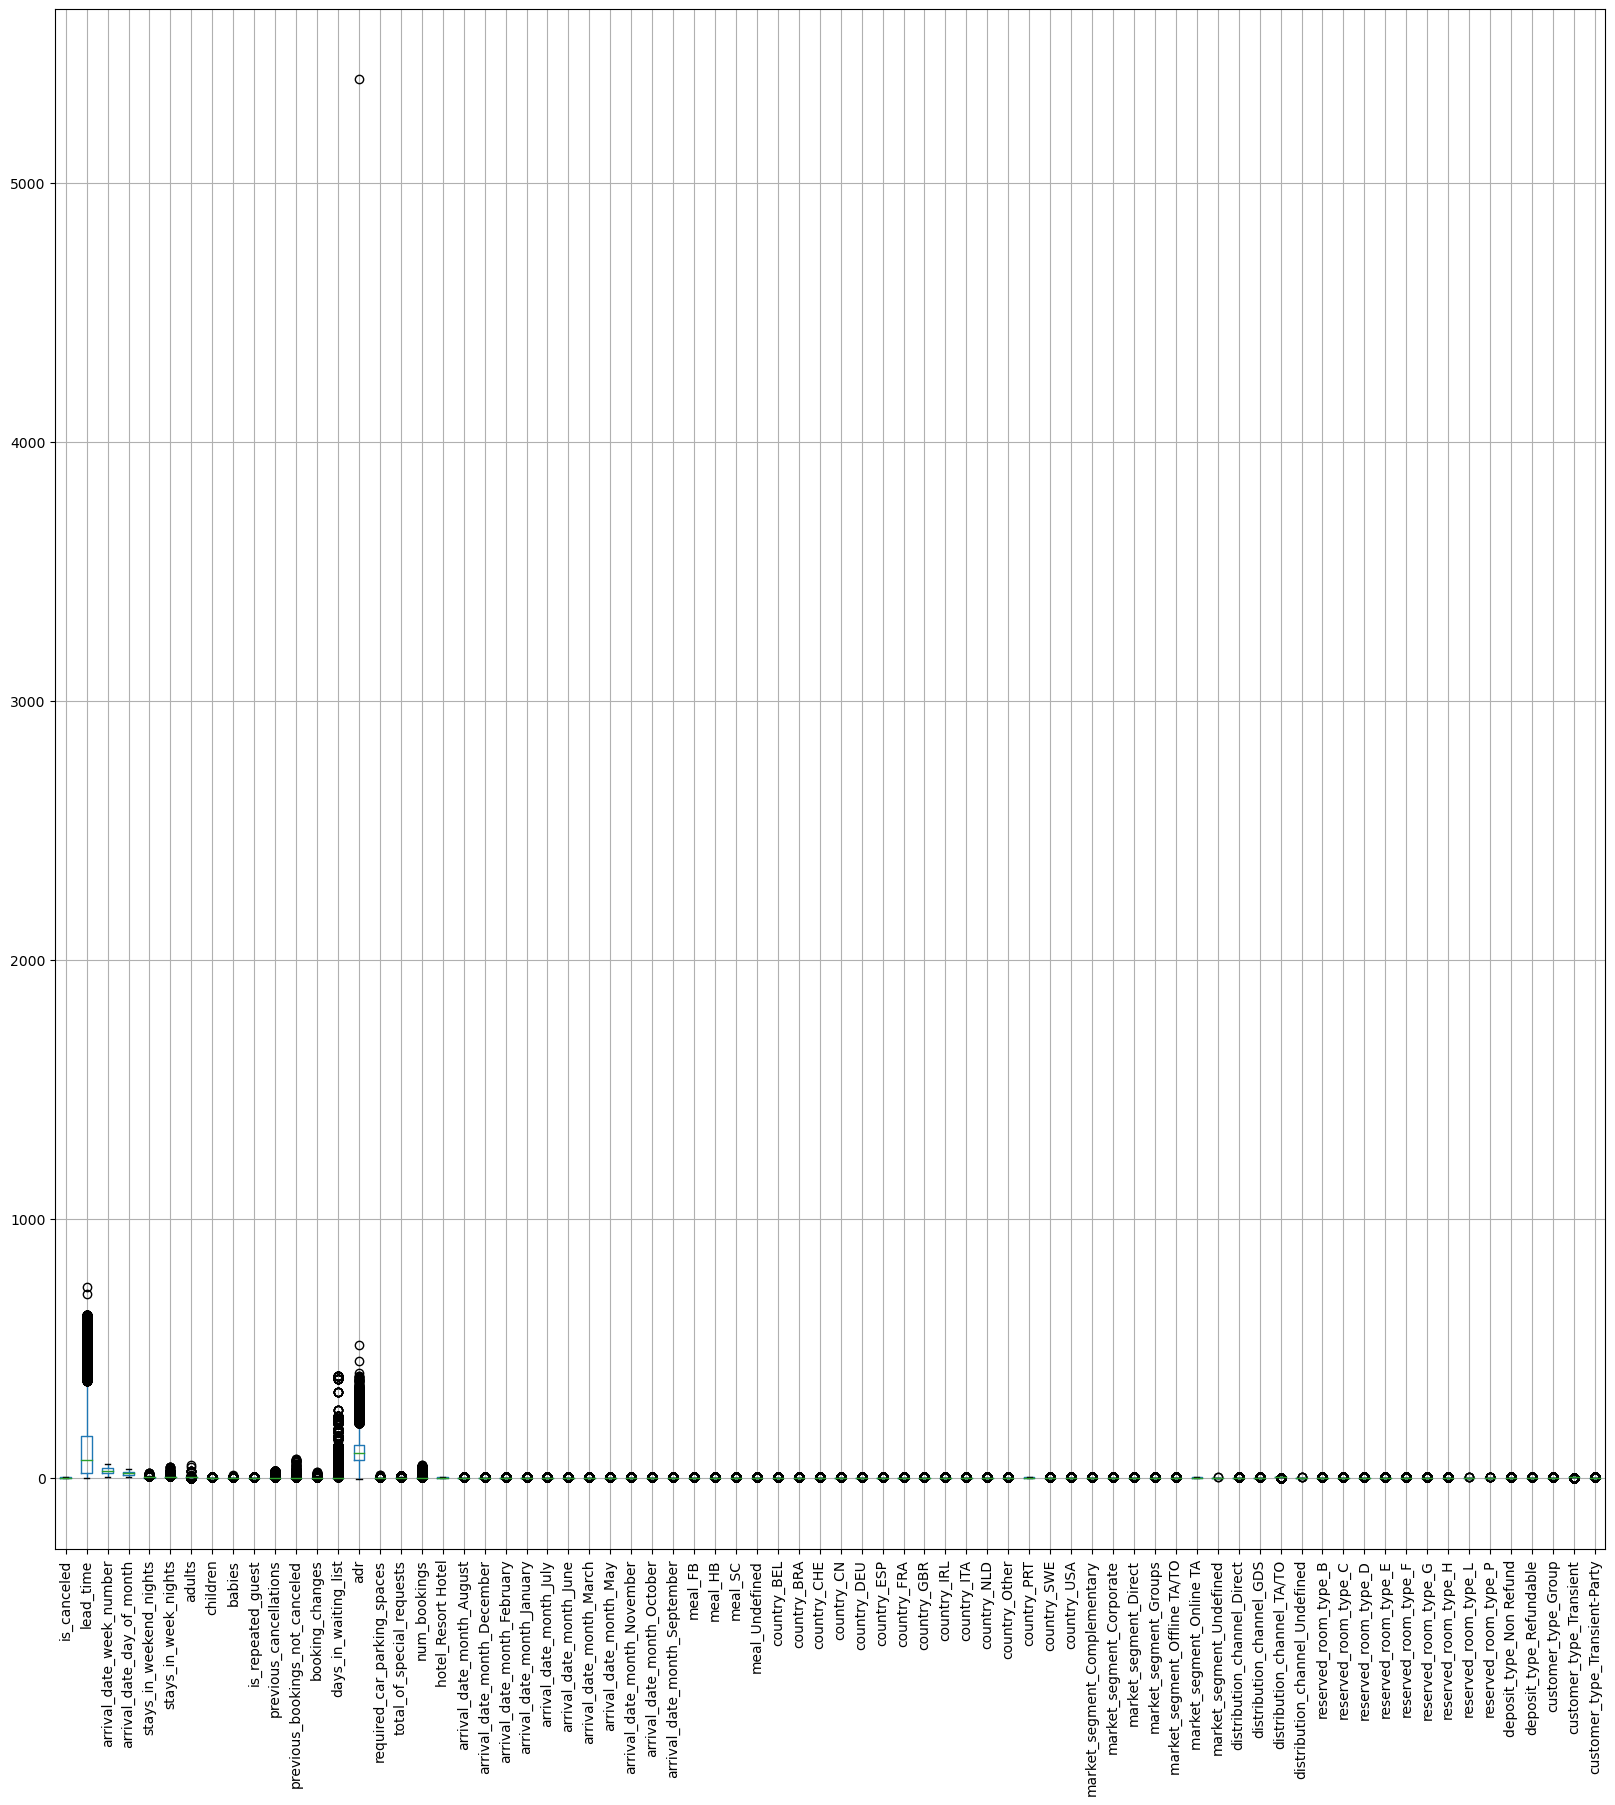

In [126]:
#Plot box plots for numerical columns to check for outliers
plt.figure(figsize=(20,20))
train.boxplot()
plt.xticks(rotation=90)


In [132]:
# Use isolation forest to remove outliers
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
pred = iforest.fit_predict(train)
score = iforest.decision_function(train)

from numpy import where
anom_index = where(pred== -1)
values = train.iloc[anom_index]
values



,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
17267,1,277,41,5,4,10,1,0.0,0,0,...,0,0,0,0,0,1,0,0,1,0
10307,1,12,8,25,2,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
17498,0,277,41,6,2,5,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
25355,0,0,26,22,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
102185,0,19,48,26,4,7,0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,0,160,25,16,2,5,2,1.0,1,0,...,0,1,0,0,0,0,0,0,1,0
27266,0,333,34,24,1,3,2,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0
24300,0,75,20,10,2,5,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
92093,0,17,27,29,0,2,3,1.0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [133]:
#Remove outliers
train = train.drop(values.index)
